<a href="https://colab.research.google.com/github/nam157/ai4theblind/blob/main/training_ssd_voc0712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import zipfile
import tarfile

data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar")

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)
    tar.close

In [2]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar")

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)
    tar.close

#### Tham khảo: VOC0712 tại [ssd.pytorch](https://github.com/amdegroot/ssd.pytorch/blob/5b0b77faa955c1917b0c710d770739ba8fbff9b7/data/voc0712.py)

### Tạo file config.py

In [2]:
import os
import os.path as osp

In [3]:
HOME = os.path.expanduser("~")
VOC_ROOT = osp.join(HOME, "/content/data/VOCdevkit")

VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')
MEANS = (104, 117, 123)
input_size = 300

### Tạo file extract annotation infomation

In [4]:
import os.path as osp
import sys
import torch
import torch.utils.data as data
import cv2
import numpy as np
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [5]:
class VOCAnnotationTransform(object):
    """Transforms a VOC annotation into a Tensor of bbox coords and label index
    Initilized with a dictionary lookup of classnames to indexes
    Arguments:
        class_to_ind (dict, optional): dictionary lookup of classnames -> indexes
            (default: alphabetic indexing of VOC's 20 classes)
        keep_difficult (bool, optional): keep difficult instances or not
            (default: False)
        height (int): height
        width (int): width
    """

    def __init__(self, class_to_ind=None, keep_difficult=False):
        self.class_to_ind = class_to_ind or dict(
            zip(VOC_CLASSES, range(len(VOC_CLASSES))))
        self.keep_difficult = keep_difficult

    def __call__(self, target, width, height):
        """
        Arguments:
            target (annotation) : the target annotation to be made usable
                will be an ET.Element
        Returns:
            a list containing lists of bounding boxes  [bbox coords, class name]
        """
        res = []
        for obj in target.iter('object'):
            difficult = int(obj.find('difficult').text) == 1
            if not self.keep_difficult and difficult:
                continue
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')

            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            bndbox = []
            for i, pt in enumerate(pts):
                cur_pt = int(bbox.find(pt).text) - 1
                # scale height or width
                cur_pt = cur_pt / width if i % 2 == 0 else cur_pt / height
                bndbox.append(cur_pt)
            label_idx = self.class_to_ind[name]
            bndbox.append(label_idx)
            res += [bndbox]  # [xmin, ymin, xmax, ymax, label_ind]
    
        return res  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [6]:
##test   VOCAnnotationTransform
img_file_path = '/content/data/VOCdevkit/VOC2007/JPEGImages/000005.jpg'
img = cv2.imread(img_file_path)
height, width, channels = img.shape

xml = ET.parse('/content/data/VOCdevkit/VOC2007/Annotations/000005.xml').getroot()

anno = VOCAnnotationTransform()
annotation_infor = anno(xml, width, height)
print(annotation_infor)

[[0.524, 0.56, 0.646, 0.9013333333333333, 8], [0.328, 0.7013333333333334, 0.504, 0.9893333333333333, 8], [0.48, 0.5146666666666667, 0.588, 0.7946666666666666, 8]]


Tạo file load dataset VOC 2007+2012

In [7]:
class VOCDetection(data.Dataset):
    """VOC Detection Dataset Object
    input is image, target is annotation
    Arguments:
        root (string): filepath to VOCdevkit folder.
        image_set (string): imageset to use (eg. 'train', 'val', 'test')
        transform (callable, optional): transformation to perform on the
            input image
        target_transform (callable, optional): transformation to perform on the
            target `annotation`
            (eg: take in caption string, return tensor of word indices)
        dataset_name (string, optional): which dataset to load
            (default: 'VOC2007')
    """

    def __init__(self, root,
                 image_sets=[('2007', 'trainval'), ('2012', 'trainval')],
                 transform=None, target_transform=VOCAnnotationTransform(),
                 dataset_name='data'):
        self.root = root
        self.image_set = image_sets
        self.transform = transform
        self.target_transform = target_transform
        self.name = dataset_name
        self._annopath = osp.join('%s', 'Annotations', '%s.xml')
        self._imgpath = osp.join('%s', 'JPEGImages', '%s.jpg')
        self.ids = list()
        for (year, name) in image_sets:
            rootpath = osp.join(self.root, 'VOC' + year)
            for line in open(osp.join(rootpath, 'ImageSets', 'Main', name + '.txt')):
                self.ids.append((rootpath, line.strip()))

    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)

        return im, gt

    def __len__(self):
        return len(self.ids)

    def pull_item(self, index):
        img_id = self.ids[index]

        target = ET.parse(self._annopath % img_id).getroot()
        img = cv2.imread(self._imgpath % img_id)
        height, width, channels = img.shape

        if self.target_transform is not None:
            target = self.target_transform(target, width, height)

        if self.transform is not None:
            target = np.array(target)
            img, boxes, labels = self.transform(img, target[:, :4], target[:, 4])
            # to rgb
            img = img[:, :, (2, 1, 0)]
            # img = img.transpose(2, 0, 1)
            target = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return torch.from_numpy(img).permute(2, 0, 1), target, height, width
        # return torch.from_numpy(img), target, height, width

    def pull_image(self, index):
        '''Returns the original image object at index in PIL form
        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.
        Argument:
            index (int): index of img to show
        Return:
            PIL img
        '''
        img_id = self.ids[index]
        return cv2.imread(self._imgpath % img_id, cv2.IMREAD_COLOR)

    def pull_anno(self, index):
        '''Returns the original annotation of image at index
        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.
        Argument:
            index (int): index of img to get annotation of
        Return:
            list:  [img_id, [(label, bbox coords),...]]
                eg: ('001718', [('dog', (96, 13, 438, 332))])
        '''
        img_id = self.ids[index]
        anno = ET.parse(self._annopath % img_id).getroot()
        gt = self.target_transform(anno, 1, 1)
        return img_id[1], gt

    def pull_tensor(self, index):
        '''Returns the original image at an index in tensor form
        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.
        Argument:
            index (int): index of img to show
        Return:
            tensorized version of img, squeezed
        '''
        return torch.Tensor(self.pull_image(index)).unsqueeze_(0)

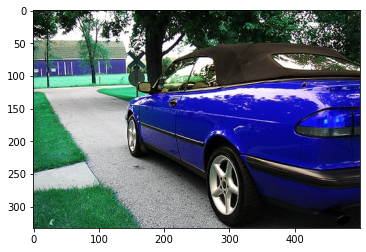

('000007', [[140.0, 49.0, 499.0, 329.0, 6]])
(tensor([[[ 27,  11,  10,  ...,  86,  46,  28],
         [177, 201,   0,  ...,  64,  94,  51],
         [ 30,  77,  33,  ...,  22,   0,  44],
         ...,
         [ 42,  10,  46,  ...,  13,  16,  17],
         [ 30,  97,  44,  ...,  20,  27,  22],
         [ 35,  65,  16,  ...,  17,  23,  20]],

        [[ 35,  20,  21,  ..., 114,  75,  58],
         [189, 213,  12,  ...,  93, 124,  83],
         [ 47,  95,  51,  ...,  54,  31,  84],
         ...,
         [101,  67,  98,  ...,  14,  17,  18],
         [ 88, 152,  93,  ...,  21,  28,  23],
         [ 87, 114,  61,  ...,  18,  24,  21]],

        [[ 58,  34,  18,  ...,  85,  49,  33],
         [195, 215,   4,  ...,  67,  99,  58],
         [ 20,  72,  34,  ...,  35,   5,  56],
         ...,
         [ 81,  46,  74,  ...,  12,  15,  16],
         [ 70, 133,  73,  ...,  19,  26,  21],
         [ 77, 100,  42,  ...,  16,  22,  19]]], dtype=torch.uint8), [[0.28, 0.14714714714714713, 0.998, 0.98

In [8]:
#test
import matplotlib.pyplot as plt
data = VOCDetection('/content/data/VOCdevkit',image_sets=[('2007', 'trainval')],transform=None, target_transform=VOCAnnotationTransform(),dataset_name='VOC0712')
img = data.pull_image(1)
plt.imshow(img)
plt.show()

print(data.pull_anno(1))
print(data.pull_item(1))

In [9]:
!git clone https://github.com/nam157/ai4theblind.git

fatal: destination path 'ai4theblind' already exists and is not an empty directory.


In [10]:
import sys
sys.path.insert(0,'/content/ai4theblind/object_detection')

In [30]:
from data.data_loader.dataset import MyDataset, my_collate_fn
from utils.augmentation import Compose, ConvertFromInts, ToAbsoluteCoords, \
    PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, \
    ToPercentCoords, Resize, SubtractMeans
from lib import *
from data.data_loader.make_datapath import make_datapath_list
from data.data_loader.dataset import MyDataset, my_collate_fn
from data.data_loader.transform import DataTransform
from data.data_loader.extract_inform_annotation import Anno_xml
from models.model import SSD
from multiboxloss import MultiBoxLoss

In [31]:
class SSDAugmentation(object):
    def __init__(self, size=300, mean=(104, 117, 123)):
        self.mean = mean
        self.size = size
        self.augment = Compose([
            ConvertFromInts(),
            ToAbsoluteCoords(),
            PhotometricDistort(),
            Expand(self.mean),
            RandomSampleCrop(),
            RandomMirror(),
            ToPercentCoords(),
            Resize(self.size),
            SubtractMeans(self.mean)
        ])

    def __call__(self, img, boxes, labels):
        return self.augment(img, boxes, labels)

In [32]:
dataset = VOCDetection(VOC_ROOT,transform=SSDAugmentation())

In [33]:
data_loader = torch.utils.data.DataLoader(dataset, 32, num_workers=4,shuffle=True, collate_fn=my_collate_fn,pin_memory=True)

In [34]:
batch_iterator = iter(data_loader)

In [35]:
images, targets = next(batch_iterator)

In [36]:
images.shape

torch.Size([32, 3, 300, 300])

In [39]:
def train(num_epochs):

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("device:", device)
  torch.backends.cudnn.benchmark = True

  #1. load dataset
  dataset = VOCDetection(root=VOC_ROOT,transform=SSDAugmentation(300,MEANS))
  data_loader = torch.utils.data.DataLoader(dataset, 32,shuffle=True, collate_fn=my_collate_fn)
  batch_iterator = iter(data_loader)
  
  #2. network
  cfg = {
    "num_classes": 21, #VOC data include 20 class + 1 background class
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
    }
  
  net = SSD(phase = 'train', cfg = cfg)
  vgg_weight = torch.load('/content/ai4theblind/object_detection/data/weights/vgg16_reducedfc.pth')
  net.vgg.load_state_dict(vgg_weight)

  def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

  # Khoi tao theo cong thuc He init va truyen weight vao cac mang extras,loc,conf

  net.extras.apply(weights_init)
  net.loc.apply(weights_init)
  net.conf.apply(weights_init)

  #3. LOSS
  criterion = MultiBoxLoss(jaccard_threshold=0.5, neg_pos=3, device=device)

  #4. Optimizer
  optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

  #5. Training
  net.to(device)
  epoch_train_loss = 0.0
  iteration = 1
  for epoch in range(num_epochs+1):
    t_epoch_start = time.time()
    t_iter_start = time.time()
    print("---"*20)
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("---"*20)
    images, targets = next(batch_iterator)
    net.train()
    images.to(images)
    targets = [ann.to(device) for ann in targets]
    #forward
    out = net(images)
    #backprop
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
    optimizer.step() 
    if iteration % 10 == 0:
         print("Iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec".format(iteration, loss.item()))
    iteration += 1
    epoch_train_loss += loss.item()
    print("Epoch {} || epoch_train_loss: {:.4f} ||".format(epoch+1, epoch_train_loss))
    epoch_train_loss = 0.0
    if ((epoch+1) % 10 == 0):
          torch.save(net.state_dict(), "ssd300_" + str(epoch+1) + ".pth")

In [40]:
train(10)

device: cpu
------------------------------------------------------------
Epoch 1/10
------------------------------------------------------------
Epoch 1 || epoch_train_loss: 26.5543 ||
------------------------------------------------------------
Epoch 2/10
------------------------------------------------------------
Epoch 2 || epoch_train_loss: 24.1480 ||
------------------------------------------------------------
Epoch 3/10
------------------------------------------------------------
Epoch 3 || epoch_train_loss: 21.5150 ||
------------------------------------------------------------
Epoch 4/10
------------------------------------------------------------
Epoch 4 || epoch_train_loss: 18.6407 ||
------------------------------------------------------------
Epoch 5/10
------------------------------------------------------------
Epoch 5 || epoch_train_loss: 16.6396 ||
------------------------------------------------------------
Epoch 6/10
---------------------------------------------------

IndexError: ignored